In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import seaborn as sns

import arviz as az ## This is new, but it is installed along with PyMC

## This is new for working with DAGs, you will have to install it
## uncomment the next box and run it
import causalgraphicalmodels as cgm
from causalgraphicalmodels import CausalGraphicalModel


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def credible_interval_from_samples(samples, prob):
    """`samples` can be an nd array. Assume that all of the dimensions
    except for the last index parameters while the last (rightmost)
    dimension indexes the samples."""
    samples_sorted = sort(samples, axis=-1)
    N_samples = samples.shape[-1]
    index = int(N_samples*(1 - prob)/2)
    lower = samples_sorted[..., index]
    upper = samples_sorted[..., -index]
    ## quantile(x, [(1 - prob)/2, (1 + prob)/2], axis=-1)
    return lower, upper

Populating the interactive namespace from numpy and matplotlib


In [2]:
# !pip install git+https://github.com/BirkhoffG/causalgraphicalmodels.git

# Thought experiment: predicting height from leg length
## ... but suppose we do multiple regression on the length of both the left and right leg.
We will generate a dataset to explore the idea.

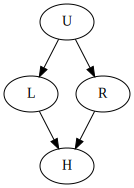

In [3]:
## U is an unknown factor that determines both leg lengths
CausalGraphicalModel(
    nodes=['L', 'R', 'H', 'U'], edges=[('U', 'L'), ('U', 'R'), ('L', 'H'), ('R', 'H')]
).draw()

In [4]:
N = 100
height = normal(10, 2, N)
leg_prop = linspace(0.4, 0.5, N)
leg_left = leg_prop*height + normal(0, 0.02, N)
leg_right = leg_prop*height + normal(0, 0.02, N)

### Now we imagine that this is a real dataset and that we want to use multiple regression to study the height predicted by the height of both legs
\begin{align*}
H_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_{L}L_i + \beta_{R}R_i \\
\alpha &\sim \text{Normal}(10, 100) \\
\beta_L &\sim \text{Normal}(2, 10) \\
\beta_R &\sim \text{Normal}(2, 10) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
Note that just like the book, we are using "...very vague, bad priors here, just so that we can be sure that the priors aren't responsible for what is about to happen."

In [5]:
with pm.Model() as model_H_LR:
    sigma = pm.Exponential('sigma', 1)
    beta_L = pm.Normal('beta_L', mu=2, sigma=10)
    beta_R = pm.Normal('beta_R', mu=2, sigma=10)
    alpha = pm.Normal('alpha', mu=10, sigma=100)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_L*leg_left + beta_R*leg_right
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H = pm.Normal('height', mu=mu, sigma=sigma, observed=height)
    ## MCMC
    _H_LR_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H_LR_posterior, var_names=['beta_L', 'beta_R', 'alpha', 'sigma']))
H_LR_posterior = _H_LR_posterior.posterior.to_dataframe()
az.plot_forest(_H_LR_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

ValueError: Not enough samples to build a trace.

### Let's compare to the single variable regression. We will see that the variability for $\beta_L$ and $\beta_R$ is unusually large.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_L  2.020  0.061   1.908    2.134      0.002    0.001    1382.0    1569.0   
alpha   0.910  0.283   0.404    1.459      0.008    0.005    1358.0    1425.0   
sigma   0.641  0.046   0.560    0.728      0.001    0.001    2127.0    2082.0   

        r_hat  
beta_L    1.0  
alpha     1.0  
sigma     1.0  


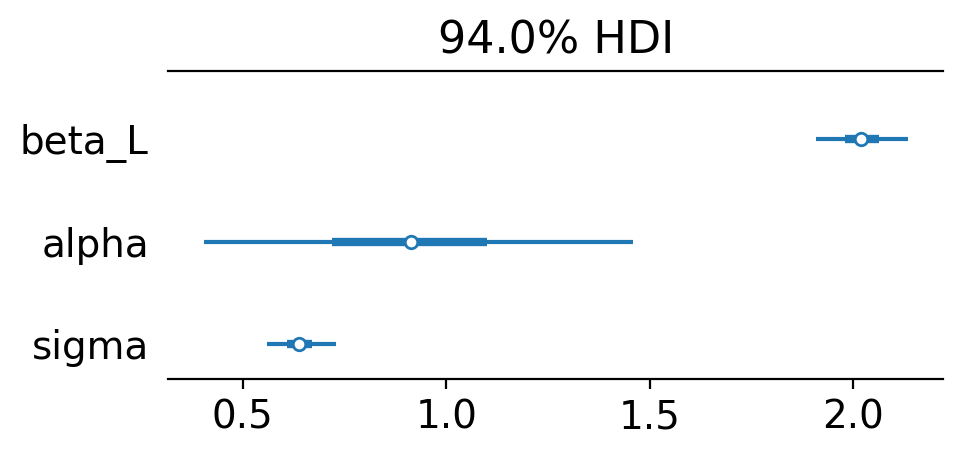

In [6]:
with pm.Model() as model_H_L:
    sigma = pm.Exponential('sigma', 1)
    beta_L = pm.Normal('beta_L', mu=2, sigma=10)
    alpha = pm.Normal('alpha', mu=10, sigma=100)
    ## Note that an underscore '_' is nothing special;
    ## it is just another character that can be part of a variable name.
    _mu = alpha + beta_L*leg_left
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H = pm.Normal('height', mu=mu, sigma=sigma, observed=height)
    ## MCMC
    _H_L_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H_L_posterior, var_names=['beta_L', 'alpha', 'sigma']))
H_L_posterior = _H_L_posterior.posterior.to_dataframe()
az.plot_forest(_H_L_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

## The model is telling us that we know $\beta_L + \beta_R$ very well, but not $\beta_L - \beta_R$
It shows that $\beta_L + \beta_R \approx 2$. On the other hand, $\beta_L - \beta_R$ can be anything so long as $\beta_L + \beta_R \approx 2$.

A simple scatter plot of the posterior samples shows that the two parameters are negatively correlated.

In [7]:
plot(H_LR_posterior['beta_R'], H_LR_posterior['beta_L'], '.')
xlabel(r'$\beta_R$', fontsize=24)
ylabel(r'$\beta_L$', fontsize=24);

NameError: name 'H_LR_posterior' is not defined

### A plot of the parameter posterior densities for $\beta_L + \beta_R$ and $\beta_L - \beta_R$
We also show a density for $\beta_L$ from the single variable regression we did above. It matches very well with $\beta_L + \beta_R$ from the two variable regression.
The second density plot for $\beta_L - \beta_R$ shows **much** more variability (look at the range of credible values). In fact, I'm not sure the Gaussian-like distribution is accurate here; remember, MCMC only gives us approximations, and they can sometimes fail.

### Summary: the weird variability in the posterior for $\beta_L$ and $\beta_R$ stems from the model's inability to determine $\beta_L - \beta_R$ from the data.
This is an example of **non-identifiability.**

The height is conditionally independent both ways:
  1. given $L$, $R$ has give no additional information about $H$: $p(H | L, R) = p(H | L)$
  2. given $R$, $L$ has give no additional information about $H$: $p(H | L, R) = p(H | R)$

In [ ]:
fig = figure(1, [12, 4])

fig.add_subplot(121)
sns.kdeplot(H_LR_posterior['beta_L'] + H_LR_posterior['beta_R'], label=r'$\beta_L + \beta_R$')
sns.kdeplot(H_L_posterior['beta_L'], label='single variable\nregression')
xlabel(r'$\beta_L + \beta_R$', fontsize=24)
ylabel('density', fontsize=20);

fig.add_subplot(122)
sns.kdeplot(H_LR_posterior['beta_L'] - H_LR_posterior['beta_R'])
xlabel(r'$\beta_L - \beta_R$', fontsize=24)
ylabel('density', fontsize=20);

# Example: Effect of anti-fungal soil treatment on plant growth
Fungal growth inhibits plant growth. But the anti-fungal soil treatment inhibits fungal growth. We want to show that the treatment has a positive effect on plant growth.

In [ ]:
CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T'],
    edges=[('H0', 'H1'), ('F', 'H1'), ('T', 'F')]
).draw()

In [ ]:
N = 100
height_initial = normal(10, 2, N)
treatment = ones(N)
treatment[:N//2] = 0 ## integer division N//2 will always return an integer (insteaed of float)
## if the treatment is present (value = 1) then the probability of fungus is 0.1
## otherwise, if treatment=0, then the fungus is present with probability 0.5
fungus = stats.bernoulli.rvs(p=0.5 - treatment*0.4, size=N)
height_t1 = normal(height_initial + 5 - 3*fungus, 1, N)

## We will assume the above is a real dataset and build some models
### First, let's see what $H_0$ by itself tells us about $H_1$

In [ ]:
with pm.Model() as model_H1_H0:
    sigma = pm.Exponential('sigma', 1)
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H1_H0_posterior, var_names=['p', 'sigma']))
H1_H0_posterior = _H1_H0_posterior.posterior.to_dataframe()
az.plot_forest(_H1_H0_posterior, var_names=["~mu"], combined=True, figsize=[5, 2]);

In [ ]:
with pm.Model() as model_H1_H0TF:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.2)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    beta_F = pm.Normal('beta_F', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment + beta_F*fungus)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0TF_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H1_H0TF_posterior, var_names=['beta_T', 'beta_F', 'alpha', 'sigma']))
H1_H0TF_posterior = _H1_H0TF_posterior.posterior.to_dataframe()
az.plot_forest(
    _H1_H0TF_posterior,
    var_names=['beta_T', 'beta_F', 'alpha', 'sigma'],
    combined=True,
    figsize=[5, 2]);

## The model is telling us that if we know $F$ then $T$ tells us nothing about growth
If we misinterpret this, it seems to tell us that treatment has no effect on growth.
But really it is telling us that once we know if fungus is present, knowing if the treatment was given tells us nothing about the growth.
This is because the treatment inhibits fungal growth, so if we see fungal growth then presumably the treatment was either not given or was ineffective.


### If we condition on $F$ we make $H_1$ independent of $T$
### ...we block the path from $T$ to $H_1$

In [ ]:
anti_fungal = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T'], edges=[('H0', 'H1'), ('F', 'H1'), ('T', 'F')]
)
anti_fungal.draw()

### We can show the conditional independencies implied by the graph

In [ ]:
all_independencies = anti_fungal.get_all_independence_relationships()
for s in all_independencies:
    if 'H1' in [s[0], s[1]]: ## Print only the independencies involving H1
        print(s[0], 'is independent of', s[1], 'given', s[2])

## So we should not use $F$ in our model?
Let's try

In [ ]:
with pm.Model() as model_H1_H0T:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.2)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0T_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H1_H0T_posterior, var_names=['beta_T', 'alpha', 'sigma']))
H1_H0T_posterior = _H1_H0T_posterior.posterior.to_dataframe()
az.plot_forest(_H1_H0T_posterior, var_names=['beta_T', 'alpha', 'sigma'], combined=True, figsize=[5, 2]);

### The above shows that once we remove the conditioning on the presence of fungus, our model shows a positive effect of the treatment on growth

## Summary: conditioning on $F$ closes the path between $H_1$ and $T$

# Example: Anti-fungal soil treatment: Version 2
## Let's change the plant growth model slightly so that fungal growth has no effect on plant growth
Add in the unobserved effect of moisture $M$

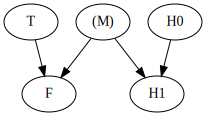

In [8]:
anti_fungal2 = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T', '(M)'], edges=[('H0', 'H1'), ('T', 'F'), ('(M)', 'H1'), ('(M)', 'F')]
)
anti_fungal2.draw()

In [ ]:
N = 100
height_initial = normal(10, 2, N)
treatment = ones(N)
treatment[:N//2] = 0
moisture = stats.bernoulli.rvs(p=0.5, size=N)
fungus = stats.bernoulli.rvs(p=0.5 - treatment*0.4 + moisture*0.4, size=N)
height_t1 = height_initial + normal(5 + 3*moisture, 1, N)

## Rerun models again

In [ ]:
with pm.Model() as model_H1_H0TF:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.2)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    beta_F = pm.Normal('beta_F', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment + beta_F*fungus)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0TF_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H1_H0TF_posterior, var_names=['beta_T', 'beta_F', 'alpha', 'sigma']))
H1_H0TF_posterior = _H1_H0TF_posterior.posterior.to_dataframe()

## The above seems to tell us that fungus helps the plants grow!
Look at $\beta_F$
### This time treatment should not affect growth
Does this agree with $\beta_T$?

In [ ]:
with pm.Model() as model_H1_H0T:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Lognormal('alpha', mu=0, sigma=0.2)
    beta_T = pm.Normal('beta_T', mu=0, sigma=0.5)
    p = pm.Deterministic('p', alpha + beta_T*treatment)
    _mu = p*height_initial
    mu = pm.Deterministic('mu', _mu) ## we use this so that we can sample the posterior predictive later
    H1 = pm.Normal('height1', mu=mu, sigma=sigma, observed=height_t1)
    ## MCMC
    _H1_H0T_posterior = pm.sample(1000, tune=1000, cores=4)
    print(pm.summary(_H1_H0T_posterior, var_names=['beta_T', 'alpha', 'sigma']))
H1_H0T_posterior = _H1_H0T_posterior.posterior.to_dataframe()

## The above tells us that removing the conditioning on presence of fungus still tells us that treatment has no association with growth, as expected

In [ ]:
## F is an example of a collider, which closes the path between H1 and T
## unless we open it by conditioning on F
anti_fungal2 = CausalGraphicalModel(
    nodes=['H0', 'H1', 'F', 'T', '(M)'], edges=[('H0', 'H1'), ('T', 'F'), ('(M)', 'H1'), ('(M)', 'F')]
)
anti_fungal2.draw()

## Summary: conditioning on $F$ opens a path from $H_1$ to $T$
-------------------------------

# Example: Collider Bias:
## Trustworthiness, Newsworthiness, and Selection of research grants
The path through a collider is closed unless we condition on the collider variable (in this case $S$). Conditioning on $S$ opens the path between $T$ and $N$, creating spurious correlation between them.

**Note that this is the opposite of the age, marriage, divorce relationship in our first example. The arrows are pointing in the opposite direction.**

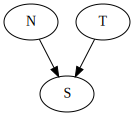

In [9]:
CausalGraphicalModel(
    nodes=['T', 'S', 'N'], edges=[('T', 'S'), ('N', 'S')]
).draw()

In [10]:
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = normal(size=N)
tw = normal(size=N)
# select top 10% of combined scores
score = nw + tw  # total score
q = quantile(score, 1 - p)  # top 10% threshold
selected = score >= q
cor = corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.86200636],
       [-0.86200636,  1.        ]])

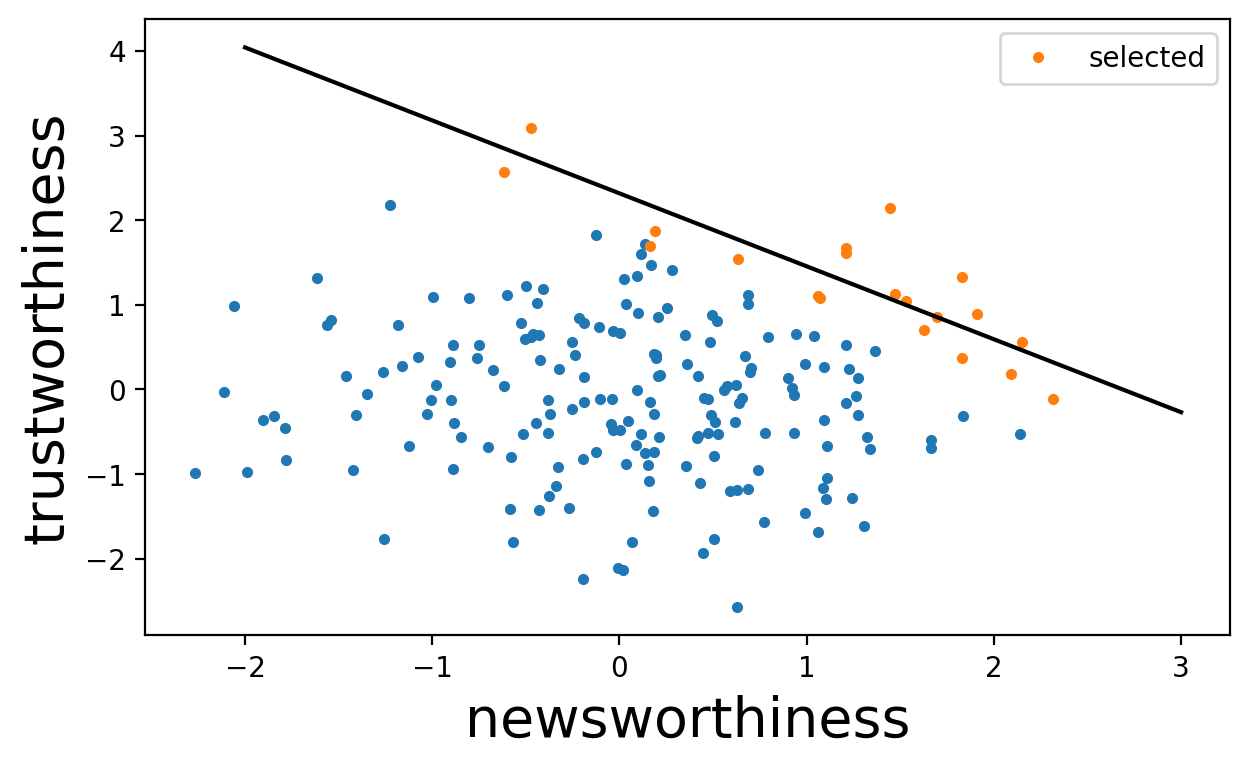

In [11]:
figure(1, [7, 4])

plot(nw[selected == False], tw[selected == False], '.')
plot(nw[selected], tw[selected], '.', label='selected')
legend()

# correlation line
xn = array([-2, 3])
plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()), 'k')

xlabel('newsworthiness', fontsize=20)
ylabel('trustworthiness', fontsize=20);

## Summary: conditioning on a collider variable opens a path between two variables
---------------------

# Example: The haunted DAG: predicting child education from parent education and grandparent education
The DAG is "haunted" by $U$ an unobserved effect of neighborhood on parent and child education

**This is an important and very counter intuitive example, and I am leaving it as an exercise.**

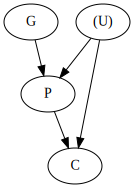

In [12]:
CausalGraphicalModel(
    nodes=['G', 'P', 'C', '(U)'], edges=[('G', 'P'), ('P', 'C'), ('(U)', 'P'), ('(U)', 'C')]
).draw()

# The four elemental confounds
  1. The Fork
  2. The Pipe
  3. The Collider
  4. The Descendant
  
### Think of situations where we want to predict outcome variable Y with predictor variable X

# Definition: A Path
A path between two nodes is given by following the arrows from one node to another, **ignoring the direction of the arrows**

## 1. Fork

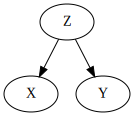

In [13]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('Z', 'X'), ('Z', 'Y')]
).draw()

### Path from X to Y is open
### can be closed by conditioning on Z

## 2. Pipe

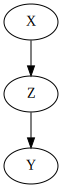

In [14]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('X', 'Z'), ('Z', 'Y')]
).draw()

### Path from X to Y is open
### can be closed by conditioning on Z

## 3. Collider

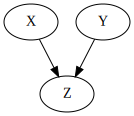

In [15]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z'], edges=[('X', 'Z'), ('Y', 'Z')]
).draw()

### Path from X to Y is closed
### can be opened by conditioning on Z

## 4. Descendant

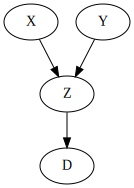

In [16]:
CausalGraphicalModel(
    nodes=['X', 'Y', 'Z', 'D'], edges=[('X', 'Z'), ('Y', 'Z'), ('Z', 'D')]
).draw()

### Path from X to Y is closed
### can be opened by conditioning on Z or on D

# Example: Removing confounds in a DAG
## Assume that we want to predict outcome $Y$ with predictor $X$


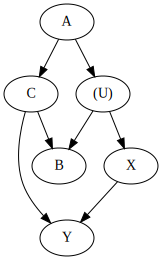

In [17]:
CausalGraphicalModel(
    nodes=['A', 'B', 'C', 'X', 'Y', '(U)'],
    edges=[('X', 'Y'), ('(U)', 'X'), ('(U)', 'B'), ('A', '(U)'), ('A', 'C'), ('C', 'B'), ('C', 'Y')]
).draw()

## Look for "backdoor" paths (arrows going into $X$)
There should be two additional "backdoor" paths

  1. X <- (U) -> B <- C -> Y
  2. X <- (U) <- A -> C -> Y
  
## Are the paths "open" or "closed"?
## If any are open, how do we close it?

# Example: Backdoor waffles
  1. S is whether the state is in the "South"
  2. W is the number of Waffle Houses
  3. D is divorce rate
  4. M is marriage rate
  5. A is median age at marriage
  
## We want to understand the effect of W on D

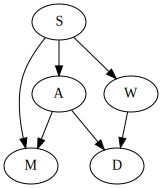

In [18]:
CausalGraphicalModel(
    nodes=['A', 'D', 'S', 'M', 'W'],
    edges=[('A', 'M'), ('A', 'D'), ('S', 'A'), ('S', 'W'), ('S', 'M'), ('W', 'D')]
).draw()

## There are three backdoor paths
  1.
  2.
  3.